Copyright **`(c)`** 2023 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

# LAB9

Write a local-search algorithm (eg. an EA) able to solve the *Problem* instances 1, 2, 5, and 10 on a 1000-loci genomes, using a minimum number of fitness calls. That's all.

### Deadlines:

* Submission: Sunday, December 3 ([CET](https://www.timeanddate.com/time/zones/cet))
* Reviews: Sunday, December 10 ([CET](https://www.timeanddate.com/time/zones/cet))

Notes:

* Reviews will be assigned  on Monday, December 4
* You need to commit in order to be selected as a reviewer (ie. better to commit an empty work than not to commit)

In [116]:
import lab9_lib

from random import choices, randint, choice, random
from dataclasses import dataclass
from copy import copy
import numpy as np


In [117]:
PROBLEM_DIMENSIONS = [1, 2, 5, 10]
GENOTYPES_LENGTH = 1000

TOURNAMENT_SIZE = 3
MUTATION_PROBABILITY = 0.2
POPULATION_SIZE = 60 

OFFSPRING_SIZE = 10

NICHES = 3
NICHES_SIZE = POPULATION_SIZE // NICHES

SURVIVALS = POPULATION_SIZE * 2 // 3
EXINTS = POPULATION_SIZE - SURVIVALS

EXTINCTION_RATE = 0.0005

MIGRANTS = 10

In [118]:
@dataclass
class Individual:
    genotype: list[int]
    fitness: float
    

def create_population(size = POPULATION_SIZE):
    population = [
                Individual(
                    genotype=choices([0, 1], k = GENOTYPES_LENGTH),
                    fitness=None,
                )
                for _ in range(size)
            ]
    
    return population

def create_initial_genotype():
    genotype = Individual(
        genotype=choices([0, 1], k = GENOTYPES_LENGTH),
        fitness=None,
    )    
    return genotype


def select_parent(pop):
    pool=[choice(pop) for _ in range(TOURNAMENT_SIZE)]
    champion = max(pool, key=lambda i: i.fitness)
    return champion


def mutate(ind: Individual) -> Individual:
    offspring = copy(ind)

    pos = randint(0, GENOTYPES_LENGTH - 1)
    offspring.genotype[pos] = 1 - offspring.genotype[pos]

    return offspring

def one_cut_cover(ind1: Individual,ind2: Individual) ->Individual:
    cut_point=randint(0,GENOTYPES_LENGTH-1)
    offspring=Individual(fitness=None,genotype=ind1.genotype[:cut_point]+ind2.genotype[cut_point:])
    assert len(offspring.genotype) == GENOTYPES_LENGTH
    return offspring

def uniform_xover(ind1: Individual, ind2: Individual) -> Individual:
    mask1 = np.random.choice([True, False], size = GENOTYPES_LENGTH)
    mask2 = np.logical_not(mask1)
    assert np.logical_or(mask1, mask2).sum() == GENOTYPES_LENGTH
    tmp1 = np.logical_and(ind1.genotype, mask1)
    tmp2 = np.logical_and(ind2.genotype, mask2)
    new_genotype = np.logical_or(tmp1, tmp2)
    return Individual(fitness=None, genotype=new_genotype)

def or_xover(ind1: Individual, ind2: Individual) -> Individual:
    or_genotype = np.logical_xor(ind1.genotype, ind2.genotype)
    offspring_genotype = (or_genotype.astype(int)).tolist()
    return Individual(fitness=None, genotype=offspring_genotype)



Problem Dimension: 1, initial fitness: 53.70% -> final fitness: 93.80%
Number of fitness calls: 20060

Problem Dimension: 2, initial fitness: 51.40% -> final fitness: 67.60%
Number of fitness calls: 20060

Problem Dimension: 5, initial fitness: 20.89% -> final fitness: 25.87%
Number of fitness calls: 20060

Problem Dimension: 10, initial fitness: 11.35% -> final fitness: 17.87%
Number of fitness calls: 20060



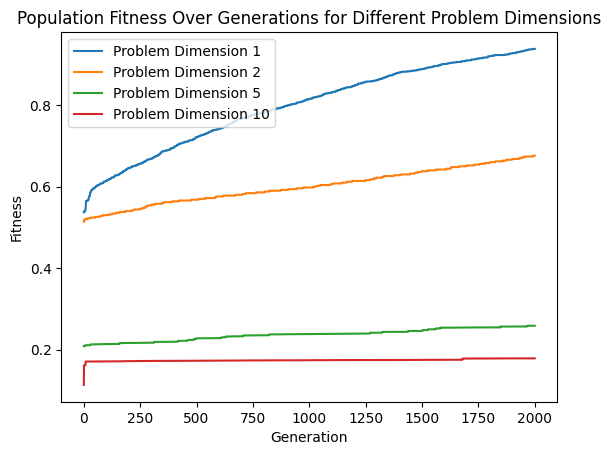

In [119]:
import matplotlib.pyplot as plt
from copy import deepcopy
from random import random

def evolutionary_algorithm(problem_dimension, initial_population, iterations=2000):
    fitness = lab9_lib.make_problem(problem_dimension)
    population = deepcopy(initial_population)

    # Initialize fitness for individuals in the initial population
    for i in population:
        i.fitness = fitness(i.genotype)

    # Sort the initial population based on fitness in descending order
    population.sort(key=lambda i: i.fitness, reverse=True)
    initial_fitness = population[0].fitness

    fitness_over_generations = [initial_fitness]

    # Main loop for evolution over generations
    for _ in range(iterations):
        offspring = list()

        for _ in range(OFFSPRING_SIZE):
            if random() < MUTATION_PROBABILITY:
                p = select_parent(population)
                o = mutate(p)
            else:
                p1 = select_parent(population)
                p2 = select_parent(population)
                o = one_cut_cover(p1, p2)

            offspring.append(o)

        # Evaluate the fitness of offspring
        for i in offspring:
            i.fitness = fitness(i.genotype)

        # Combine offspring and parents, then select the top individuals
        population.extend(offspring)
        population.sort(key=lambda i: i.fitness, reverse=True)
        population = population[:POPULATION_SIZE]

        # Record the maximum fitness in the current generation
        fitness_over_generations.append(population[0].fitness)

    # Print final results after all generations
    print(f"Problem Dimension: {problem_dimension}, initial fitness: {initial_fitness:.2%} -> final fitness: {population[0].fitness:.2%}")
    print(f"Number of fitness calls: {fitness.calls}\n")

    # Plot the fitness over generations for the given problem dimension
    plt.plot(range(iterations + 1), fitness_over_generations, label=f"Problem Dimension {problem_dimension}")

# Run the Evolutionary Algorithm for each problem dimension
for problem_dimension in PROBLEM_DIMENSIONS:
    initial_population = create_population(POPULATION_SIZE)
    evolutionary_algorithm(problem_dimension, initial_population, iterations=2000)

# Display the final plot showing the fitness over generations for different problem dimensions
plt.title("Population Fitness Over Generations for Different Problem Dimensions")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend()
plt.show()

Problem Dimension: 1, initial fitness: 53.70% -> final fitness: 95.40%
Number of fitness calls: 22560

Problem Dimension: 2, initial fitness: 25.37% -> final fitness: 71.40%
Number of fitness calls: 22560

Problem Dimension: 5, initial fitness: 21.97% -> final fitness: 35.41%
Number of fitness calls: 22580

Problem Dimension: 10, initial fitness: 15.64% -> final fitness: 20.69%
Number of fitness calls: 22820



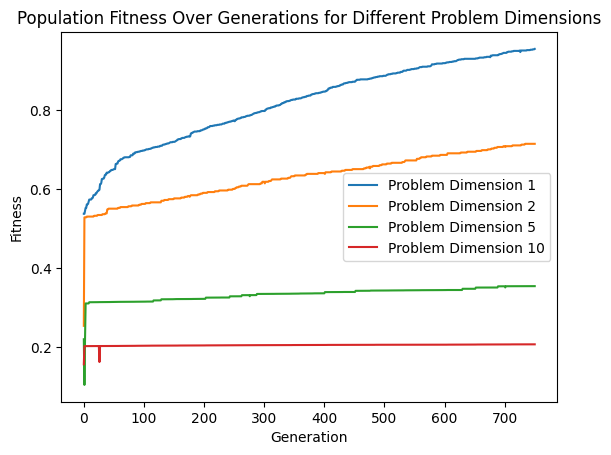

In [128]:
from random import shuffle, random, choice, choices
import matplotlib.pyplot as plt
from copy import deepcopy

def create_niches(pop, n=3):
    shuffle(pop)
    niches = [pop[i:i + len(pop)//n] for i in range(0, len(pop) + 1 - len(pop) // n, len(pop) // n)]
    return niches

def generate_offspring(population, fitness):
    offspring = []
    for _ in range(OFFSPRING_SIZE):
        if random() < MUTATION_PROBABILITY:
            p = select_parent(population)
            o = mutate(p)
        else:
            p1 = select_parent(population)
            p2 = select_parent(population)
            o = uniform_xover(p1, p2)

        offspring.append(o)

    for i in offspring:
        i.fitness = fitness(i.genotype)

    return offspring

def island_model(problem_dimension, initial_population, iterations=2000):
    fitness = lab9_lib.make_problem(problem_dimension)
    population = deepcopy(initial_population)

    # Initialize fitness for individuals in the initial population
    for i in population:
        i.fitness = fitness(i.genotype)

    # Sort the initial population based on fitness in descending order
    population.sort(key=lambda i: i.fitness, reverse=True)
    initial_fitness = population[0].fitness

    fitness_over_generations = [initial_fitness]

    # Create initial niches by shuffling the sorted population
    niches = create_niches(population, n=NICHES)
    best_fitness = 0.0

    # Main loop for evolution over generations
    for generation in range(iterations):
        # Evolve each niche independently
        for i in range(NICHES):
            offspring = generate_offspring(niches[i], fitness)
            niches[i].extend(offspring)
            niches[i].sort(key=lambda x: x.fitness, reverse=True)
            niches[i] = niches[i][:NICHES_SIZE]

        # Migration: Exchange individuals between randomly selected niches
        if generation % 25 == 0:
            niches_indexes = set(range(NICHES))
            for _ in range(MIGRANTS):
                niche1 = choice(list(niches_indexes))
                niches_indexes.remove(niche1)
                niche2 = choice(list(niches_indexes))
                niches_indexes.add(niche1)

                swap = choices(list(range(NICHES_SIZE)), k=2)
                niches[niche1][swap[0]], niches[niche2][swap[1]] = niches[niche2][swap[1]], niches[niche1][swap[0]]

        # Extinction and Recreation: Recreate the population if the difference between the
        # best fitness in the current niches and the previous best fitness is below a threshold
        if generation % 50 == 0:
            tmp_best_fitness = max([niche[0].fitness for niche in niches])
            if abs(best_fitness - tmp_best_fitness) < EXTINCTION_RATE:
                global_population = []
                for niche in niches:
                    global_population.extend(niche)

                # Sort the global population based on fitness in descending order
                global_population.sort(key=lambda x: x.fitness, reverse=True)
                global_population = global_population[:SURVIVALS]

                # Create a new population to fill the remaining slots after extinction
                new_population = create_population(size=EXINTS)
                for i in new_population:
                    i.fitness = fitness(i.genotype)

                # Combine the survivors and the new population
                global_population.extend(new_population)
                # Recreate niches with the new global population
                niches = create_niches(global_population, n=NICHES)

            # Update the best fitness if a new best fitness is found
            best_fitness = max(best_fitness, tmp_best_fitness)

        # Record the maximum fitness in the current generation
        fitness_over_generations.append(max([niche[0].fitness for niche in niches]))

    # Print final results after all generations
    print(f"Problem Dimension: {problem_dimension}, initial fitness: {initial_fitness:.2%} -> final fitness: {max([niche[0].fitness for niche in niches]):.2%}")
    print(f"Number of fitness calls: {fitness.calls}\n")

    # Plot the fitness over generations for the given problem dimension
    plt.plot(range(iterations + 1), fitness_over_generations, label=f"Problem Dimension {problem_dimension}")

# Run the island model algorithm for each problem dimension
for problem_dimension in PROBLEM_DIMENSIONS:
    initial_population = create_population(POPULATION_SIZE)
    island_model(problem_dimension, initial_population, iterations=750)

# Display the final plot showing the fitness over generations for different problem dimensions
plt.title("Population Fitness Over Generations for Different Problem Dimensions")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend()
plt.show()
